In [1]:
import numpy as np
import pandas as pd
# from pandas.api.types import is_string_dtype
import pickle
# from sklearn.linear_model import Ridge
from sklearn import linear_model
# from sklearn import neighbors
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn import svm
import warnings; warnings.filterwarnings('ignore')
# from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, train_test_split
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt


In [2]:
import lib.clean_helper as cl

## Preparing Test Set

In [3]:
test = pd.read_csv('../data/kaggle_test.csv', index_col = 'Id')

In [4]:
test = test.rename(columns={ '3SsnPorch': 'ThreeSsnPorch'})

In [5]:
ordinal_f = ['MSSubClass' ,'OverallQual',
             'OverallCond',
             'FullBath','HalfBath',
             'BedroomAbvGr','KitchenAbvGr',
             'TotRmsAbvGrd','Fireplaces',
             'MoSold', 'BsmtCond', 'BsmtQual',
             'ExterCond', 'ExterQual',
             'GarageQual', 'GarageCond',
             'HeatingQC', 'KitchenQual',
             'PoolQC']
test[ordinal_f] = test[ordinal_f].apply(cl.obj_to_ordinal)

In [6]:
test.Exterior2nd = cl.clean_ext_typos(test.Exterior2nd)

In [7]:
test = cl.nan_to_str_none(test)

#### Cleaning Years
In the test set, one house is documented as having a garge built in the year 2207. This is clearly an error. We did not find this error in the training set. The largest `GarageYrBlt` values in the training set is 2010. 

Let's replace 2207 with a nan and our code will later impute that nan. We know that there is a garage because `nan_to_str` checks if there is a garage and would have made the `GarageYrBlt` value "none". 

In [8]:
def clean_years(year_df):
    ### drop years that don't make sense; years greater than 2010
    ### dataset only includes homes sold btwn 2006 and 2010
    for f in year_df.columns:
        is_no_yr = year_df[f].isnull() + (year_df[f].astype('str') == 'none') 
        exists_yr = is_no_yr == False
        to_nan =  year_df[f][exists_yr].apply(lambda x: int(x) > 2010)
        to_replace = year_df[f][exists_yr][to_nan].tolist()
        year_df[f] = year_df[f].replace(to_replace, [np.nan] * len(to_replace))
        clean_years = year_df
        
    return clean_years

yr_feats = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
test[yr_feats] = clean_years(test[yr_feats])

In [9]:
train_df = pickle.load(open('../data/train_df.p', 'rb'))
is_num = test.dtypes.isin([np.dtype('float64'), np.dtype('int64')])
num_feats = test.dtypes.index[is_num]
for f in num_feats:
    mean = train_df[f].mean()
    test[f] = test[f].fillna(mean)

In [10]:
cat_feats = test.dtypes.index[is_num == False]
for f in cat_feats:
    mode = train_df[f].mode()[0]
    test[f] = test[f].fillna(mode)

In [11]:
test[yr_feats] = test[yr_feats].apply(cl.bin_yrs)

### One-Hot Encoding Necessary for LASSO

In [12]:
X = pickle.load(open('../data/X.p', 'rb'))
y = train_df.SalePrice

In [13]:
X_dummies = pd.get_dummies(X)

In [14]:
test_dummies = pd.get_dummies(data = test)

values_not_in_test_dummies = set(X_dummies.columns) - set(test_dummies.columns)
for v in values_not_in_test_dummies:
    test_dummies[v] = 0
test_dummies.shape

values_not_in_X = set(test_dummies.columns) - set(X_dummies.columns)
test_dummies = test_dummies.drop(columns = list(values_not_in_X))

### Scaling Necessary for LASSO
#### Why Scale Dummy Variables
There is a lot of disagreement at least on StackOverflow. We will take the recommendation of the man who literally wrote the book on LASSO and regularization, Tibshirani [THE LASSO METHOD FOR VARIABLE SELECTION IN THE COX MODEL, Statistics in Medicine, VOL. 16, 385-395 (1997)](http://statweb.stanford.edu/~tibs/lasso/fulltext.pdf)

> The lasso method requires initial standardization of the regressors, so that the penalization scheme is fair to all regressors. For categorical regressors, one codes the regressor with dummy variables and then standardizes the dummy variables. As pointed out by a referee, however, the relative scaling between continuous and categorical variables in this scheme can be somewhat arbitrary.

In [15]:
def standard_scale_train(dataframe):
    array_ = preprocessing.scale(dataframe.values)
    if isinstance(dataframe, pd.DataFrame):
        scaled_df = pd.DataFrame(array_, 
                                 index = dataframe.index,
                                 columns = dataframe.columns)
    elif isinstance(dataframe, pd.Series):
        scaled_df = pd.Series(array_,
                              index = dataframe.index)
    
    return scaled_df

In [16]:
X_scaled = standard_scale_train(X_dummies)

### Scaling Test Set

In [17]:
X_mean = X.mean()
X_std = X.std()

In [18]:
test_scaled = test_dummies.copy()
for c in test_scaled.columns:
    if c in X_mean.index:
        test_scaled[c] = test_scaled[c].apply(lambda x: (x-X_mean[c])/X_std[c])

0.7601989405963026


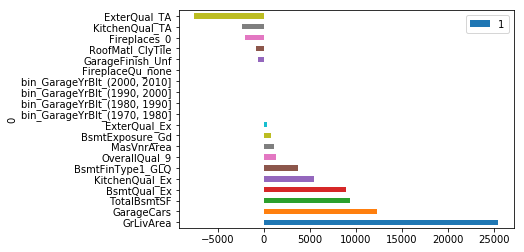

In [19]:
lasso = linear_model.Lasso(alpha=9999)
lasso.fit(X_scaled, y)
print(lasso.score(X_scaled,y))

def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of coefficients
    '''
    cols = X_scaled.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

plot_coef(lasso)

In [20]:
test_scaled = test_scaled[X_scaled.columns.tolist()]

In [21]:
submission = pd.DataFrame({'SalePrice': lasso.predict(test_scaled)},
                         index = test.index)
submission.to_csv('ames-submission-3.csv')

![rmsle](https://image.slidesharecdn.com/rmslecostfunction-160623032122/95/rmsle-cost-function-9-638.jpg?cb=1466652265)